# Preprocessing GBIF data for the creation of global trait maps.

## Contents

This block focuses on the creation of global trait maps from citizen science plant observations. The overarching idea is to link citizen science plant observations with trait information from the TRY database.
Details on this methods are described in [Wolf et al. 2022](https://drive.google.com/file/d/1vPYWmHox_LPRsleO9kzBY37ODdoh9oew/view?usp=sharing).

<div style="border:1px solid black; padding:10px">

<b>Citation:</b>

Wolf, S., Mahecha, M.D., Sabatini, F.M. et al. (2022). Citizen science plant observations encode global trait patterns. <i>Nat Ecol Evol</i>, 6, 1850–1859. [DOI: 10.1038/s41559-022-01904-x](https://doi.org/10.1038/s41559-022-01904-x)

</div>

In the context of creating global trait maps from crowd-sourced data, this section we will inspect and preprocess citizen science data derived from the Global Biodiversity Information Facility (GBIF).

This section covers:

- loading the citizen science observations from GBIF
- subsampling the GBIF data using regular grids and hexagons
- Plotting the GBIF data in space
- Plotting the GBIF data in time

## Assigments
* Which species grows where? Create a pipeline to plot the spatial distribution of single species
    * Some interesting candidates are *Ulex europaeus* or *Taraxacum officinale* (Why is *Ulex europaeus*, being native to Europe, also frequently abundant in other places?
* Use the locations of *Ulex europaeus* and *Tectona grandis* and sample annual mean temperature and precipitation values (WorldClim).
* When do citizens sample where? Map the average Day of the Year (DOY) per region and explain the resulting patterns
* Map the annual average annual growth of GBIF observations (e.g. based on 2 degree grid cells).

## Packages, etc.

In [1]:
import pandas as pd # for handling dataframes in python
import numpy as np # array handling
import os # operating system interfaces
import random
import sys

# packages needed for plotting:
import matplotlib.pyplot as plt # main Python plotting library 
import seaborn as sns # pretty plots
from matplotlib.colors import LogNorm, Normalize, BoundaryNorm
import cartopy.crs as ccrs # maps 
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap # requires mamba/conda install 'basemap'

from h3 import h3 # mamba/conda install 'h3-py'
from shapely.geometry import Polygon
from geojson import Feature, Point, FeatureCollection, Polygon


In [3]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Download GBIF observation data

This step is not required if you downloaded the data supplied for the course: https://drive.google.com/drive/folders/1hiPaQaDegKOba22Mg7ZBoOSkcNBgTMnR?usp=sharing

This data includes a data download of the  4th of January 2022 (https://doi.org/10.15468/dl.34tjre). 
If you would like to use the most recent data, follow the above link and click **'Rerun Query'** and proceed to download. For this analysis the 'simple' version is sufficient.


### Load observations as data frame
The dataset is huge. We first check which column names are present and only load the columns that are actually needed to reduce disk storage.

In [4]:
# Read the first rows of the CSV file
df = pd.read_csv("data/GBIF_0090334-210914110416597/occurrence.txt", nrows=500, sep="\t")

# print all column names of the dataframe without truncation
pd.set_option('display.max_columns', None)
df.head()

,gbifID,abstract,accessRights,accrualMethod,accrualPeriodicity,accrualPolicy,alternative,audience,available,bibliographicCitation,conformsTo,contributor,coverage,created,creator,date,dateAccepted,dateCopyrighted,dateSubmitted,description,educationLevel,extent,format,hasFormat,hasPart,hasVersion,identifier,instructionalMethod,isFormatOf,isPartOf,isReferencedBy,isReplacedBy,isRequiredBy,isVersionOf,issued,language,license,mediator,medium,modified,provenance,publisher,references,relation,replaces,requires,rights,rightsHolder,source,spatial,subject,tableOfContents,temporal,title,type,valid,institutionID,collectionID,datasetID,institutionCode,collectionCode,datasetName,ownerInstitutionCode,basisOfRecord,informationWithheld,dataGeneralizations,dynamicProperties,occurrenceID,catalogNumber,recordNumber,recordedBy,individualCount,organismQuantity,organismQuantityType,sex,lifeStage,reproductiveCondition,behavior,establishmentMeans,occurrenceStatus,preparations,disposition,associatedReferences,associatedSequences,associatedTaxa,otherCatalogNumbers,occurrenceRemarks,organismID,organismName,organismScope,associatedOccurrences,associatedOrganisms,previousIdentifications,organismRemarks,materialSampleID,eventID,parentEventID,fieldNumber,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,samplingProtocol,samplingEffort,sampleSizeValue,sampleSizeUnit,fieldNotes,eventRemarks,locationID,higherGeographyID,higherGeography,continent,waterBody,islandGroup,island,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,verbatimDepth,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,locationAccordingTo,locationRemarks,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,pointRadiusSpatialFit,verbatimCoordinateSystem,verbatimSRS,footprintWKT,footprintSRS,footprintSpatialFit,georeferencedBy,georeferencedDate,georeferenceProtocol,georeferenceSources,georeferenceVerificationStatus,georeferenceRemarks,geologicalContextID,earliestEonOrLowestEonothem,latestEonOrHighestEonothem,earliestEraOrLowestErathem,latestEraOrHighestErathem,earliestPeriodOrLowestSystem,latestPeriodOrHighestSystem,earliestEpochOrLowestSeries,latestEpochOrHighestSeries,earliestAgeOrLowestStage,latestAgeOrHighestStage,lowestBiostratigraphicZone,highestBiostratigraphicZone,lithostratigraphicTerms,group,formation,member,bed,identificationID,identificationQualifier,typeStatus,identifiedBy,dateIdentified,identificationReferences,identificationVerificationStatus,identificationRemarks,taxonID,scientificNameID,acceptedNameUsageID,parentNameUsageID,originalNameUsageID,nameAccordingToID,namePublishedInID,taxonConceptID,scientificName,acceptedNameUsage,parentNameUsage,originalNameUsage,nameAccordingTo,namePublishedIn,namePublishedInYear,higherClassification,kingdom,phylum,class,order,family,genus,subgenus,specificEpithet,infraspecificEpithet,taxonRank,verbatimTaxonRank,vernacularName,nomenclaturalCode,taxonomicStatus,nomenclaturalStatus,taxonRemarks,datasetKey,publishingCountry,lastInterpreted,elevation,elevationAccuracy,depth,depthAccuracy,distanceAboveSurface,distanceAboveSurfaceAccuracy,issue,mediaType,hasCoordinate,hasGeospatialIssues,taxonKey,acceptedTaxonKey,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,species,genericName,acceptedScientificName,verbatimScientificName,typifiedName,protocol,lastParsed,lastCrawled,repatriated,relativeOrganismQuantity,recordedByID,identifiedByID,level0Gid,level0Name,level1Gid,level1Name,level2Gid,level2Name,level3Gid,level3Name,iucnRedListCategory
0,891081513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC_BY_4_0,NaN,NaN,2020-07-16T02:40:48Z,NaN,iNaturalist.org,https://www.inaturalist.org/observations/80215,NaN,NaN,NaN,NaN,Jennifer Aitkens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iNaturalist,Observations,iNatu

For the moment, only the following columns are interesting for us: "gbifID", "kingdom", "phylum", "order", "family", "genus", "species", "scientificName", "decimalLatitude", "decimalLongitude", "hasCoordinate", "dateIdentified". We will restrict the data loading to these columns to restrict the file size.

Additionally, we will use subsampling to not load all of the data points (this would otherwise require a lot of RAM and time). Let´s estimate how many rows we can load to not exceed, eg., 2 GB of RAM:


In [5]:
# Estimate the size of the dataframe with 500 rows in memory
df = pd.read_csv("data/GBIF_0090334-210914110416597/occurrence.txt", nrows = 500, sep='\t',
                   usecols= ["gbifID", "kingdom", "phylum", "order", "family", "genus", "species", "scientificName", "decimalLatitude", "decimalLongitude", "hasCoordinate", "dateIdentified"])
# print the size of the subsample 
print("megabytes on RAM:", sys.getsizeof(df) / (1024 * 1024))

megabytes on RAM: 0.2836332321166992


In [7]:
# determine the total amount of rows in the dataset (this might take ~4 minutes). You can also skip it and use the following number = 14050292
def count_rows(file_path):
    with open(file_path, 'r') as f:
        return sum(1 for line in f)

# Assuming file_path is the path to your CSV file
file_path = "data/GBIF_0090334-210914110416597/occurrence.txt"
num_rows = count_rows(file_path)

In [8]:
# Given the above sample and the total number of rows in the dataset, we can now estimate how many rows we can read without exceeding 2 GB of RAM. You may check your system to define the available gigabytes
gigabytes = 2
num_rows_target = gigabytes * 1024 / ((sys.getsizeof(df) / df.shape[0]) / (1024 * 1024))
num_rows_target

3610296.270144682

In [9]:
# Define the probability of reading a row
p = num_rows_target/num_rows  # 0.005 = 0.5% of the lines

# Define the function to decide whether to skip a row
def skiprow(i):
    if i == 0:
        return False  # Don't skip the header
    else:
        return random.random() > p

# Read the CSV file
gbif = pd.read_csv("data/GBIF_0090334-210914110416597/occurrence.txt", skiprows=skiprow, sep='\t',
                   usecols= ["gbifID", "kingdom", "phylum", "order", "family", "genus", "species", "scientificName", "decimalLatitude", "decimalLongitude", "hasCoordinate", "dateIdentified"])

C:\Users\teja\AppData\Local\Temp\ipykernel_3376\2674621921.py:12: DtypeWarning: Columns (217) have mixed types. Specify dtype option on import or set low_memory=False.
  gbif = pd.read_csv("data/GBIF_0090334-210914110416597/occurrence.txt", skiprows=skiprow, sep='\t',


In [10]:
# Dobule-check the size of the subsample in megabytes
print("gigabytes on RAM:", sys.getsizeof(gbif) / (1024 * 1024 * 1024))
print("shape: ", gbif.shape)

gigabytes on RAM: 2.1124765062704682
shape:  (3608420, 12)


## Remove cells where no geocoordinates are available
... as such observations are useless for geospatial analysis

In [11]:
gbif = gbif[gbif["hasCoordinate"] == True]

## Create a spatial subsample of the data using reglar grids
A challenging issue when working with GBIF data is that the occurence data is not homogenously sampled around the globe: https://www.gbif.org/occurrence/map?occurrence_status=present


To reduce such effects and create a more spatially balanced sample, we can subsample the data using a regular grid so that each area is limitted to a certain number of observations.

In [12]:
# define a resolution of the sample grid in degrees
resolution = 2 

# Create a grid of cells
x_grid = np.arange(gbif['decimalLongitude'].min(), gbif['decimalLongitude'].max(), resolution)
y_grid = np.arange(gbif['decimalLatitude'].min(), gbif['decimalLatitude'].max(), resolution)

# Assign each observation to a grid cell
gbif['decimalLongitude_cell'] = np.digitize(gbif['decimalLongitude'], x_grid)
gbif['decimalLatitude_cell'] = np.digitize(gbif['decimalLatitude'], y_grid)

<Axes: >

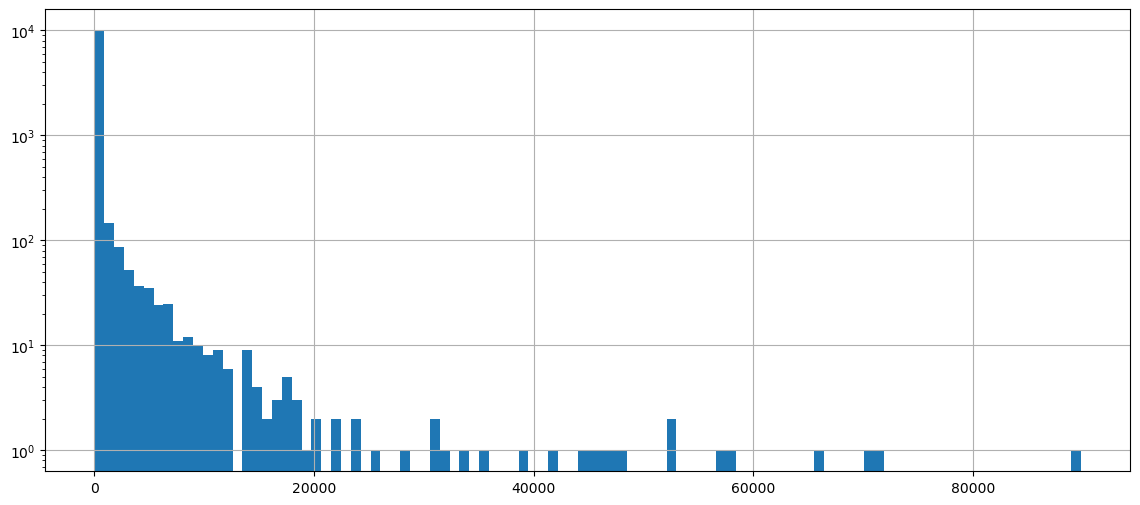

In [13]:
# group the data by the grid cells and plot a histogram
gbif_grouped = gbif.groupby(['decimalLatitude_cell', 'decimalLongitude_cell']).size().reset_index(name='count')

# plot the histogram of observations per grid cell to select an apropriate threshold for the subsampling
fig = plt.figure(figsize=(14, 6))
gbif_grouped.stack().hist(bins=100, log=True)

(local version of subsampling)

In [15]:
observations_per_cell = 1000

subsampled_gbif = gbif.groupby(['decimalLongitude_cell', 'decimalLatitude_cell']).apply(
    lambda x: x.sample(n=min(x.shape[0], observations_per_cell), replace=False)
, include_groups=False).reset_index(drop=True)

(colab version of subsampling)

In [16]:
observations_per_cell = 1000

subsampled_gbif = gbif.groupby(['decimalLongitude_cell', 'decimalLatitude_cell']).apply(
    lambda x: x.sample(n=min(x.shape[0], observations_per_cell), replace=False)
).reset_index(drop=True)

C:\Users\teja\AppData\Local\Temp\ipykernel_3376\48957409.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsampled_gbif = gbif.groupby(['decimalLongitude_cell', 'decimalLatitude_cell']).apply(


In [18]:
print(gbif.shape)
print(subsampled_gbif.shape)
print(subsampled_gbif.shape[0]/gbif.shape[0]*100)

(3597232, 14)
(810018, 14)
22.517813696753503


This looked really promising! Only ~22% of the data remained, meaning that the data indeed was concentrated for some areas. Using this subsampling, we could not only reduce the redundancy of the data in some areas (e.g. central Europe) but also further reduce the file size without loosing too much information.

However, there is one problem: Grid cells of the regular grid have different sizes from the equator to the poles. Lets plot the grid cells on a map to visualize this:

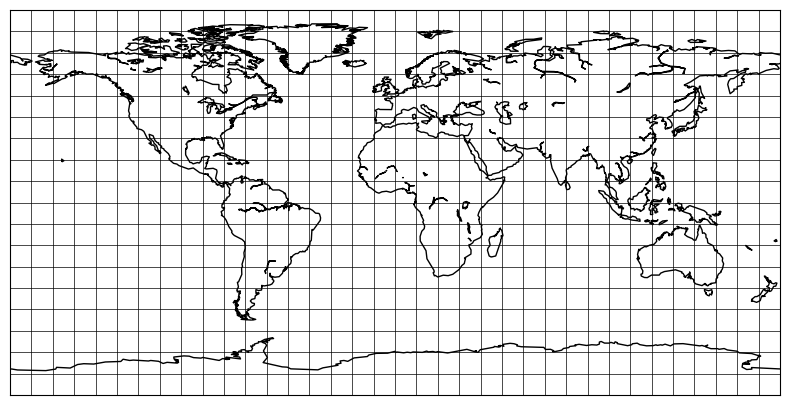

In [19]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Create a basemap
m = Basemap(projection='cyl', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)

# Draw coastlines, countries, and states
m.drawcoastlines()

# Draw the grid
y_grid_degrees = np.arange(-90, 90, 10)
x_grid_degrees = np.arange(-180, 180, 10)

# Draw lines for each latitude and longitude
for y in y_grid_degrees:
    m.plot([-180, 180], [y, y], color='black', linewidth=0.5)

for x in x_grid_degrees:
    m.plot([x, x], [-90, 90], color='black', linewidth=0.5)

# Show the plot
plt.show()

Pixels covering greenland are of the same size as at the equator, although the area is much smaller. This is because the map projection distorts the size of the pixels. Let's calculate the area of grid cells accross Lattiudes to demonstrate this:

Text(0, 0.5, 'Area (km^2)')

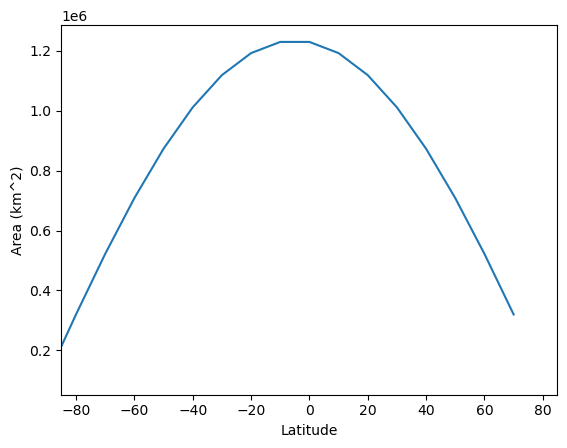

In [20]:
# Radius of the Earth in kilometers
R = 6371

# Convert latitudes to radians
y_grid_rad = np.deg2rad(y_grid_degrees)

# Calculate the area of pixels in square kilometers across latitudes
pixel_areas = 2 * np.pi * R**2 * np.abs(np.sin(y_grid_rad[:-1]) - np.sin(y_grid_rad[1:])) / len(x_grid_degrees)

plt.plot(y_grid_degrees[:-1], pixel_areas)
plt.xlabel('Latitude')
plt.xlim(-85, 85)
plt.ylabel('Area (km^2)')

Impressive, the area per pixel varies with a factor of 6 across Latitude. Thus, to create a more meaningful subsample, we should probably consider to use another geometry then regular grid cell.

## Create a spatial subsample of the data using area conform hexagons

Instead of regular grid cells, we can use hexagonal grid cells. The h3 library provides functions to convert latitude and longitude coordinates to hexagons. Infos on the h3 hexagon definition, particularly infos on the resolution, can be found here: https://h3geo.org/docs/core-library/restable/

| Res | Average Hexagon Area (km2) | Pentagon Area* (km2) | Ratio (P/H) |
|-----|----------------------------|----------------------|-------------|
| 0   | 4,357,449.416078381        | 2,562,182.162955496  | 0.5880      |
| 1   | 609,788.441794133          | 328,434.586246469    | 0.5386      |
| 2   | 86,801.780398997           | 44,930.898497879     | 0.5176      |
| 3   | 12,393.434655088           | 6,315.472267516      | 0.5096      |
| 4   | 1,770.347654491            | 896.582383141        | 0.5064      |
| 5   | 252.903858182              | 127.785583023        | 0.5053      |
| 6   | 36.129062164               | 18.238749548         | 0.5048      |
| 7   | 5.161293360                | 2.604669397          | 0.5047      |

In [21]:
# Define the function to convert lat, lon to a hexagon
def lat_lon_to_hex(lat, lon, resolution=4):
    return h3.geo_to_h3(lat, lon, resolution)

# Create a new column for the hexagon each observation belongs to
gbif['hex'] = gbif.apply(lambda row: lat_lon_to_hex(row['decimalLatitude'], row['decimalLongitude']), axis=1)

# Group by the hexagon and apply the sampling function
def sample_group(group, n_samples=1000):
    if len(group) > n_samples:
        return group.sample(n_samples)
    else:
        return group

subsampled_gbif = gbif.groupby('hex').apply(sample_group).reset_index(drop=True)

C:\Users\teja\AppData\Local\Temp\ipykernel_3376\1153352132.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsampled_gbif = gbif.groupby('hex').apply(sample_group).reset_index(drop=True)


In [22]:
print(gbif.shape)
print(subsampled_gbif.shape)
print(subsampled_gbif.shape[0]/gbif.shape[0]*100)

(3597232, 15)
(2305270, 15)
64.08455167751205


In this case, ~23 % of the original observations remained after subsampling.

## Lets save the data to a file so we dont have to repeat all over again

In [23]:
os.makedirs("exports", exist_ok=True)
gbif.to_csv("exports/gbif_preporcessed.csv", index=False)
subsampled_gbif.to_csv("exports/gbif_preporcessed_subsample.csv", index=False)

In [24]:
subsampled_gbif = pd.read_csv("exports/gbif_preporcessed_subsample.csv")

## Excursion: Plot the global distribution of hexagons used for sub-sampling

Plotting h3 objects (hexagons) is not so trivial. We just want to run the following code and not get into details

In [25]:
H3_res = 2
def geo_to_h3(row):
  return h3.geo_to_h3(row['decimalLatitude'], row['decimalLongitude'],resolution = H3_res)

In [26]:
subsampled_gbif['h3_cell'] = subsampled_gbif.apply(geo_to_h3,axis=1)

In [27]:
gbif_g = (subsampled_gbif
                          .groupby('h3_cell')
                          .gbifID
                          .agg(list)
                          .to_frame("ids")
                          .reset_index())
# Let's count each points inside the hexagon
gbif_g['count'] = (gbif_g['ids']
                      .apply(lambda gbifID:len(gbifID)))
gbif_g.sort_values('count',ascending=False)

,h3_cell,ids,count
605,822a17fffffffff,"[2823332544, 1986511980, 1453405902, 259779493...",34011
630,822b9ffffffffff,"[2557738863, 3070533666, 3321194418, 331420936...",32967
614,822aaffffffffff,"[3338116601, 3301871437, 3399377401, 333071084...",32727
607,822a37fffffffff,"[3408208290, 3355239229, 3343965204, 335519059...",30755
601,8229a7fffffffff,"[1453439893, 2626223390, 2573936078, 145338908...",30616
...,...,...,...
596,822937fffffffff,[2237420630],1
592,8228e7fffffffff,[2235478467],1
579,822827fffffffff,[2992827347],1
1026,8252a7fffffffff,[1993777693],1


In [28]:
from shapely.geometry import Polygon
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['h3_cell'], True)
  return Polygon(points)
#Apply function into our dataframe
gbif_g['geometry'] = (gbif_g.apply(add_geometry,axis=1))

In [29]:
from geojson import Feature, Point, FeatureCollection, Polygon
def hexagons_dataframe_to_geojson(df_hex, hex_id_field,geometry_field, value_field,file_output = None):

    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)

    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)

    else :
      return feat_collection

In [30]:
geojson_obj = (hexagons_dataframe_to_geojson
                (gbif_g,
                 hex_id_field='h3_cell',
                 value_field='count',
                 geometry_field='geometry'))

In [31]:
import geopandas as gpd
gpd.GeoDataFrame.from_features(geojson_obj["features"])

,geometry,value
0,"POLYGON ((46.68072 79.52276, 55.75077 79.55833...",4
1,"POLYGON ((29.20747 75.65094, 35.20921 76.15221...",1
2,"POLYGON ((23.09478 78.07801, 30.10563 78.74785...",29
3,"POLYGON ((40.01140 75.01232, 46.11008 75.23051...",1
4,"POLYGON ((24.49265 69.30502, 28.25587 69.84475...",138
...,...,...
1879,"POLYGON ((-67.53629 -53.64397, -64.79714 -53.5...",1
1880,"POLYGON ((-72.44091 -57.60288, -69.36273 -57.6...",1
1881,"POLYGON ((-71.86355 -54.93567, -69.04143 -54.9...",122
1882,"POLYGON ((-44.80144 -62.99451, -41.24530 -62.3...",1


In [32]:
gdf = gpd.GeoDataFrame.from_features(geojson_obj['features'])
gdf['area'] = gdf['geometry'].area
index = gdf[gdf["area"] < gdf["area"].quantile(0.95)].index

# select the features of index_as_int from geosjon_obj
features = geojson_obj
features['features'] = [geojson_obj['features'][i] for i in index]

In [33]:
import plotly.express as px
import nbformat
fig = (px.choropleth_mapbox(
                    gbif_g, 
                    geojson=features, 
                    locations='h3_cell', 
                    color='count',
                    color_continuous_scale="Viridis",
                    range_color=(0,gbif_g['count'].mean()           ),                  mapbox_style='carto-positron',
                    zoom=0,
                    center = {"lat": 65.469211, "lon": -136.713865},
                    opacity=0.7,
                    labels={'count':'# of observations '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

... this plot nicely represents the advantage of heaving hexagon representation for area-conform data sampling. You can hover over the cells to inspect the number of observations per cell.

## Some basic stats and info on the plant species

In [13]:
gbif = pd.read_csv('exports/gbif_preporcessed.csv')
subsampled_gbif = pd.read_csv('exports/gbif_preporcessed_subsample.csv')

In [34]:
print("number of species:", subsampled_gbif["scientificName"].nunique())

number of species: 70957


In [35]:
subsampled_gbif["scientificName"].head()

0         Cochlearia groenlandica L.
1                Saxifraga cernua L.
2                Saxifraga cernua L.
3                Saxifraga cernua L.
4    Papaver radicatum Rottb. ex DC.
Name: scientificName, dtype: object

There are different ways to name species. Let us generalize the dataset a bit: Keep only the first two words of scientific name, as some names are annotated with additional information.

In [36]:
subsampled_gbif['scientificName']  = subsampled_gbif['scientificName'].apply(lambda x: ' '.join(x.split()[0:2]))
subsampled_gbif["scientificName"].head()

0    Cochlearia groenlandica
1           Saxifraga cernua
2           Saxifraga cernua
3           Saxifraga cernua
4          Papaver radicatum
Name: scientificName, dtype: object

### Frequency distribution of observations

In [37]:
species_frequencies = subsampled_gbif['scientificName'].value_counts()
species_frequencies

scientificName
Achillea millefolium          10191
Trifolium repens               6925
Taraxacum officinale           6726
Trifolium pratense             6581
Chamaenerion angustifolium     6578
                              ...  
Sobralia roezlii                  1
Maxillaria equitans               1
Calea sessiliflora                1
Anthurium oblongocordatum         1
Pinguicula antarctica             1
Name: count, Length: 63112, dtype: int64

Most species have only been observed one or two times, few species have been observed many times. The most observed species is *Achillea millefolium*:
https://en.wikipedia.org/wiki/Achillea_millefolium
Have you ever seen this plant species?

Distribution of frequency unique species ist highly squewed. Most species are rare and few are common, as we can see in the following histogramm:

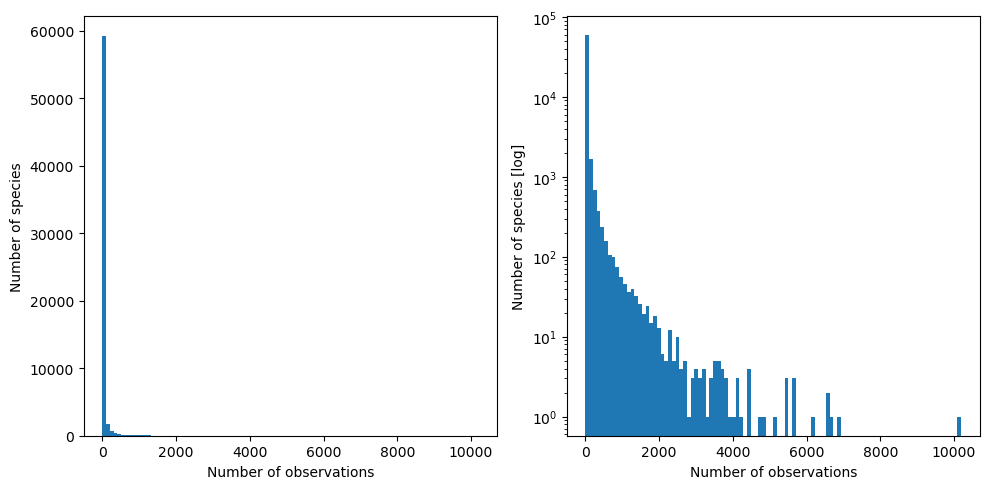

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(species_frequencies, bins = 100, log=False)
axs[0].set_xlabel('Number of observations')
axs[0].set_ylabel('Number of species')

axs[1].hist(species_frequencies, bins = 100, log=True)
axs[1].set_xlabel('Number of observations')
axs[1].set_ylabel('Number of species [log]')

plt.tight_layout()
plt.show()

## Plotting
### Spatial density of observations

One version of plotting the density, is by aggregating the GBIF observations in hexagonal bins and count the number of observations per hexagon. The function ```hexbin``` provides this functionality.

In [40]:
def hexmap(long, lat, label):
    
    ax = plt.subplot(projection=ccrs.PlateCarree())
    
    # add coastline outline and extent of map:
    ax.coastlines(resolution='110m', color='orange', linewidth=1)
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    
    # hexbin aggregates observations in hexagonal bins and plots the density
    hb = ax.hexbin(long,
          lat, 
          mincnt=1, # min. nuber of observations per hexagon 
          gridsize=(100, 30), # bin size
          cmap="cool", 
          transform=ccrs.PlateCarree(), 
          bins='log', 
          extent=[-180, 180, -90, 90],
          linewidths=0.1)
    cb = fig.colorbar(hb, ax=ax, shrink=0.4)
    cb.set_label(label)

Apply the ```hexmap``` function to our GBIF observations and save output as ```.pdf```. We plot both the gbif data as well as the subsampled GBIF data (based on hexagons):

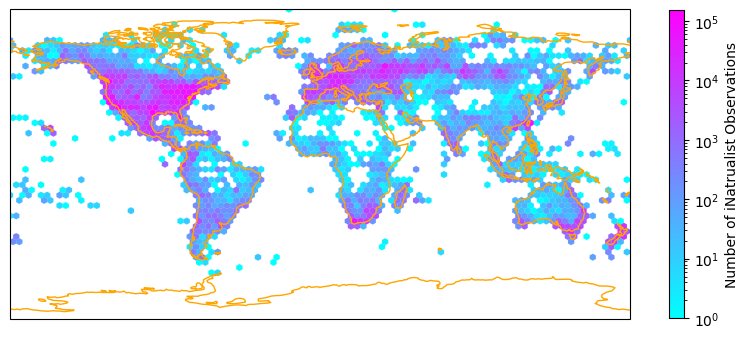

In [41]:
fig = plt.figure(figsize=(10, 10))
hexmap(gbif['decimalLongitude'], gbif['decimalLatitude'], "Number of iNatrualist Observations")
plt.savefig('figures/gbif_density_hex_tight.pdf', bbox_inches='tight')

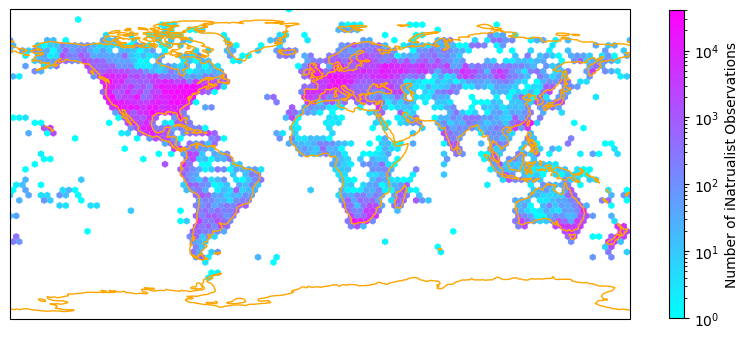

In [26]:
fig = plt.figure(figsize=(10, 10))
hexmap(subsampled_gbif['decimalLongitude'], subsampled_gbif['decimalLatitude'], "Number of iNatrualist Observations")
plt.savefig('figures/gbif_density_hex_tight.pdf', bbox_inches='tight')

### Recap: What´s again the fuzz with projections?
A second plotting option is to grid the data into a latitude/longitude grid. Then we can project our map onto a more realistic representation of the spherical Earth, such as the Robinson projection. The previously used ```hexbin``` function does not have a reprojection functionality implemented.

In [42]:
def gridmap(long, lat, label, projection, colorbar=True):
    
    plt.rcParams.update({'font.size': 15})

    Z, xedges, yedges = np.histogram2d(np.array(long,dtype=float),
                                   np.array(lat),bins = [181, 91])

    #https://stackoverflow.com/questions/67801227/color-a-2d-histogram-not-by-density-but-by-the-mean-of-a-third-column
    #https://medium.com/analytics-vidhya/custom-strava-heatmap-231267dcd084
    
    #let function know what projection provided data is in:
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    cmap = plt.get_cmap('cool')
    im_ratio = Z.shape[0]/Z.shape[1]

    #plot map
    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=projection) # I used the PlateCarree projection from cartopy
    
    # set figure to map global extent (-180,180,-90,90)
    ax.set_global()
    
    #add coastlines
    ax.coastlines(resolution='110m', color='orange', linewidth=1.3)
    
    #add grid with values
    im = ax.pcolormesh(xedges, yedges, Z.T, cmap="cool", norm=LogNorm(), transform=data_crs)
    
    
    #add color bar
    if colorbar==True:
        fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, shrink=0.3, location="left", label=label)


Apply the ```gridmap``` function to our GBIF observations and save output as ```.pdf```.

You can also experiment with other projections.
For inspriations or explanations see
* https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
* https://mathigon.org/course/circles/spheres-cones-cylinders#sphere-maps

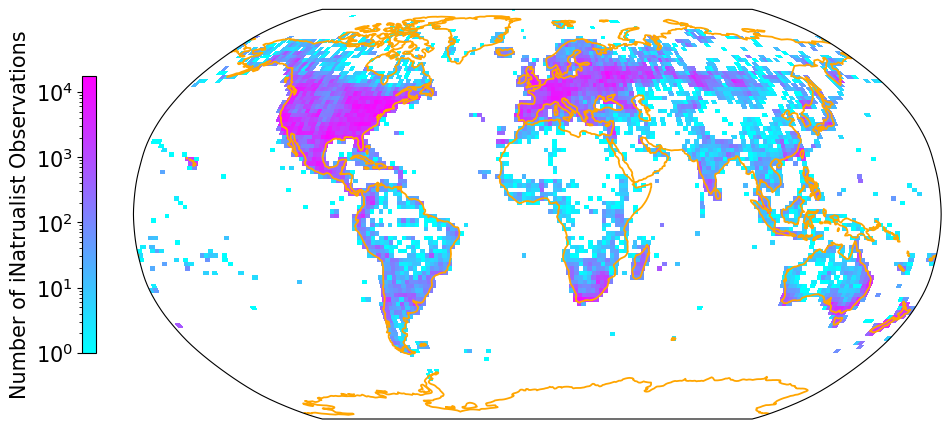

In [28]:
fig = plt.figure(figsize=(12, 12))
gridmap(subsampled_gbif['decimalLongitude'], subsampled_gbif['decimalLatitude'], "Number of iNatrualist Observations", ccrs.Robinson())
plt.savefig('figures/iNat_density_Robinson_all.pdf', bbox_inches='tight')

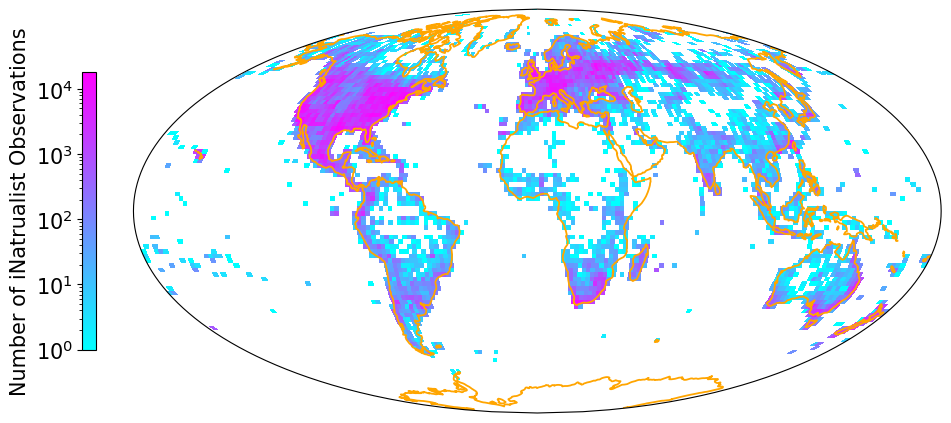

In [29]:
fig = plt.figure(figsize=(12, 12))
gridmap(subsampled_gbif['decimalLongitude'], subsampled_gbif['decimalLatitude'], "Number of iNatrualist Observations", ccrs.Mollweide())
plt.savefig('figures/iNat_density_Mollweide_all.pdf', bbox_inches='tight')

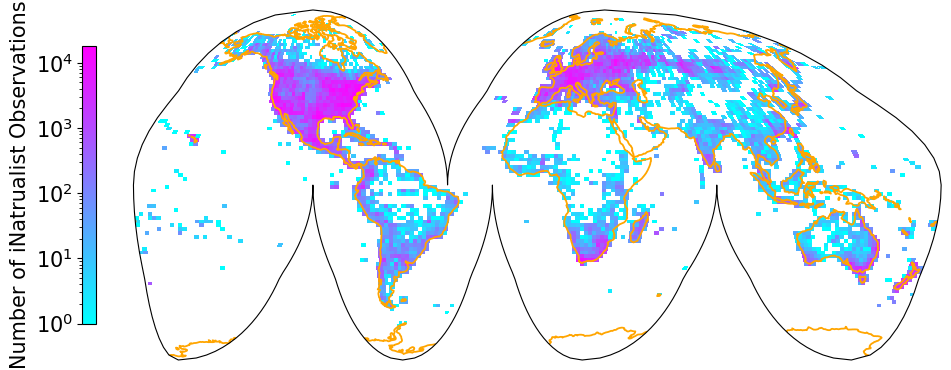

In [30]:
fig = plt.figure(figsize=(12, 12))
gridmap(subsampled_gbif['decimalLongitude'], subsampled_gbif['decimalLatitude'], "Number of iNatrualist Observations", ccrs.InterruptedGoodeHomolosine())
plt.savefig('figures/iNat_density_Goode_all.pdf', bbox_inches='tight')

### Explore growth of observations over time

The number of iNaturalist observations added every year is growing continually. Here we plot the growth of observations added every year (using the so-called "date identified") since the iNaturalist project started in 2008.

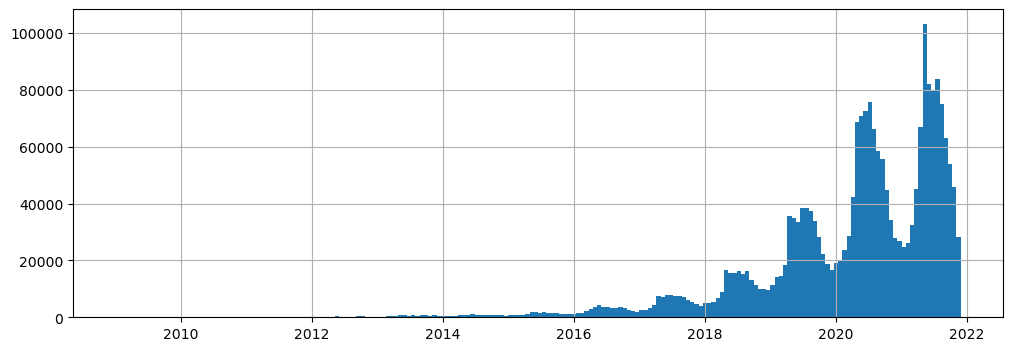

In [43]:
# plot a histogtram of the eventDate of the dataframe
fig = plt.figure(figsize=(12, 4))
subsampled_gbif['dateIdentified'] = pd.to_datetime(subsampled_gbif['dateIdentified'])
subsampled_gbif['dateIdentified'].hist(bins=200)
plt.show()

Why do we have such a oszillating pattern in the histogram?

Let´s some into a single year

C:\Users\teja\AppData\Local\Temp\ipykernel_3376\1900062391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



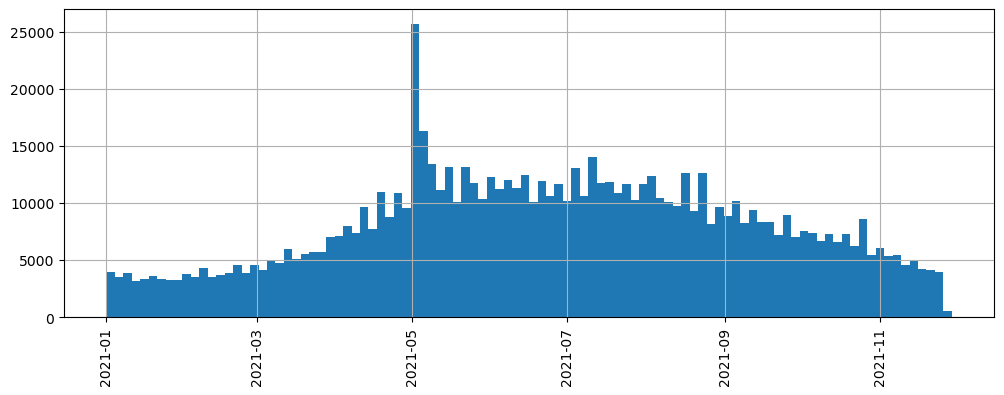

In [44]:
# plot a histogtram of the eventDate of the dataframe
fig = plt.figure(figsize=(12, 4))
gbif_2021 = subsampled_gbif[subsampled_gbif['dateIdentified'].dt.year == 2021]
gbif_2021['dateIdentified'] = pd.to_datetime(gbif_2021['dateIdentified'])
gbif_2021['dateIdentified'].hist(bins=100)
plt.xticks(rotation='vertical')
plt.show()

There is something going on in early Mai. Let´s zoom in:

C:\Users\teja\AppData\Local\Temp\ipykernel_3376\3673964643.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



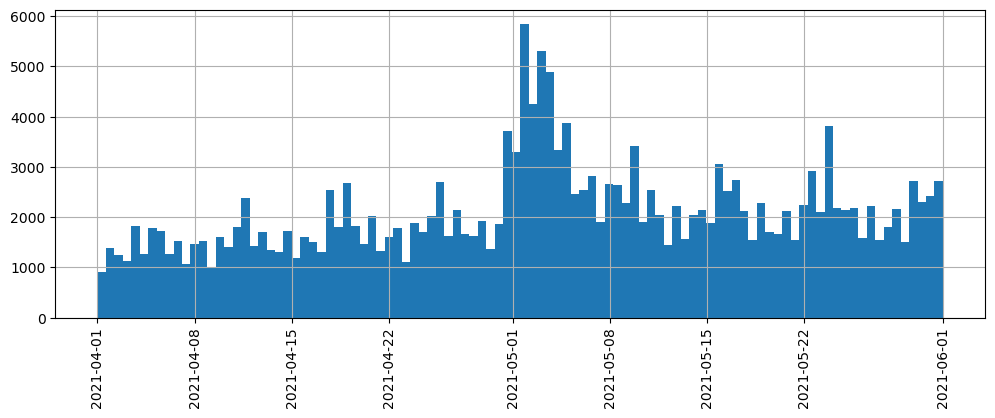

In [45]:
fig = plt.figure(figsize=(12, 4))
gbif_2021['dateIdentified'] = pd.to_datetime(gbif_2021['dateIdentified'])
gbif_2021_sub = gbif_2021.loc[(gbif_2021['dateIdentified'].dt.month == 4) | (gbif_2021['dateIdentified'].dt.month == 5)]
gbif_2021_sub['dateIdentified'].hist(bins=100)
plt.xticks(rotation='vertical')
plt.show()

...ah, humans seem to love to go out on weekends, holidays and in summer: https://academic.oup.com/bioscience/article-abstract/71/11/1179/6357804

...and there is a global bioblizz event: https://www.citynaturechallenge.org/
* *User activity is highest from May to September but with an increase in activity through the month of April and substantial spikes in total observations and unique users during organized events, such as the City Nature Challenge in late April, during which organizers in cities hold global events to encourage participants to record as many observations as they can in a single weekend (see https://citynaturechallenge.org; figure 1b). City Nature Challenges are a specific instance of a wider effort by iNaturalist to encourage and provide infrastructure to support bioblitzes, which are communal efforts to record as many species in a given location and time period as possible (www.inaturalist.org/pages/bioblitz+guide).*

Lets plot a clear yearly growth then:

In [46]:
# derive the year as an integer
subsampled_gbif['dateIdentified'] = pd.to_datetime(subsampled_gbif['dateIdentified'])
subsampled_gbif['year'] = subsampled_gbif['dateIdentified'].dt.year
subsampled_gbif['year'] = subsampled_gbif['year'].fillna(-1).astype(int) # errorneous values are set to -1

In [47]:
def catbarplot(df, column, label):
    
    # sort dataframe by column 
    df = df.sort_values(by=[column])
    
    # white background 
    sns.set_theme(style="white")
    
    ax = sns.countplot(x=column, data=df, palette="cool",)
    
    # make remove top and right border of plot
    sns.despine()
    
    # set label text
    plt.xlabel(column)
    plt.ylabel(label) 
    
    # rotate x tick labels sightly
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

C:\Users\teja\AppData\Local\Temp\ipykernel_3376\1946535632.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\teja\AppData\Local\Temp\ipykernel_3376\1946535632.py:19: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



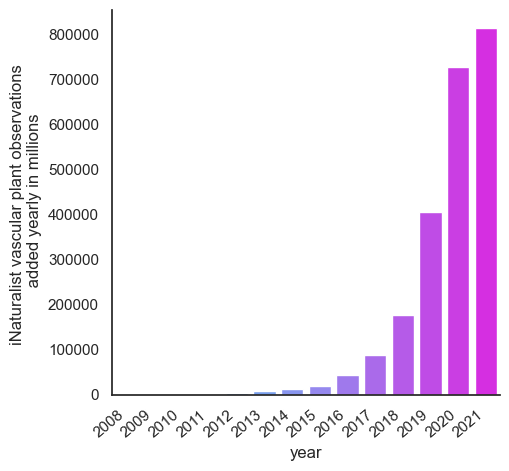

In [48]:
plt.figure(figsize=(5,5))
# plot while ignoring errorneous values (-1)
catbarplot(subsampled_gbif[subsampled_gbif['year'] != -1], "year", "iNaturalist vascular plant observations \n added yearly in millions")
plt.savefig('figures/gbif_growth.pdf', bbox_inches='tight')